trainable = Falseについて  
https://qiita.com/obsproth/items/d7c53580b847fe762da7

learning rate スケジュールについて  

fine turningについて  
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/


途中からのfine turning  
https://www.tensorflow.org/guide/keras/transfer_learning

In [4]:
import os
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import cv2
from PIL import Image
from matplotlib import pyplot as plt
# import tensorflow.keras.backend as K

import tensorflow as tf

ImportError: dlopen(/Users/ryusei/anaconda3/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so, 2): Library not loaded: @rpath/_pywrap_tensorflow_internal.so
  Referenced from: /Users/ryusei/anaconda3/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so
  Reason: image not found

In [ ]:
import pandas as pd, numpy as np
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [ ]:
pip install efficientnet albumentations

In [ ]:
! unzip test_images.zip

# データの読み込み

In [5]:
all_image_paths = files_train
all_image_labels = df_train.class_num

files_train = tf.io.gfile.glob(['./train_images/{}'.format(x) for x in df_train.id])
labels_train = [int(x) for x in df_train.class_num]

NameError: name 'files_train' is not defined

In [6]:
df_train = pd.read_csv("train_images.csv")
df_test = pd.read_csv("test_images.csv")
df = pd.concat([df_train, df_test]).reset_index(drop = True)

df_image_id = df.id
df_class = df.class_num

In [7]:
df = pd.concat([df_train, df_test]).reset_index(drop = True)

# 各種設定

In [30]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
IMG_SIZES = [224, 240, 260, 300, 380, 456, 528, 600]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [12]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [0, 1, 2, 3, 4, 5, 6, 7]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [31]:
BATCH_SIZES

[32, 32, 32, 32, 32]

In [32]:
DATADIR_TRAIN = "./train_images/"
DATADIR_TEST = "./test_images/"

In [33]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
# AUTOTUNEはGPUの処理とCPUの処理の配分を動的に設定してくれるパラメータ
AUTOTUNE     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


# データの前処理

In [34]:
from albumentations.core.transforms_interface import ImageOnlyTransform

def resize_square(img):
    """長辺のサイズで正方形の画像に"""
    l=max(img.shape[:2])
    
    h,w = img.shape[:2]
    hm = (l-h)//2
    wm = (l-w)//2
    return cv2.copyMakeBorder(img,
                            hm,
                            hm+(l-h)%2,
                            wm,
                            wm+(l-w)%2,
                            cv2.BORDER_CONSTANT,
                            value=0)

In [35]:
class CropLemon(ImageOnlyTransform):
    """レモンが写っている部分をcrop"""

    def __init__(self, margin=10, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.margin = margin

    def get_box(self, img):
        """ 中央に近い黄色い領域を見つける """
        h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))

        # h,v のしきい値で crop
        _, img_hcrop = cv2.threshold(h, 0, 40, cv2.THRESH_BINARY)
        _, img_vcrop = cv2.threshold(v, v.mean(), 255, cv2.THRESH_BINARY)
        th_img = (img_hcrop * (img_vcrop / 255)).astype(np.uint8)

        contours, hierarchy = \
            cv2.findContours(th_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        # サイズの大きいものだけ選択
        contours = [c for c in contours if cv2.contourArea(c) > 10000]
        if not contours: return None

        # 中央に近いものを選択
        center = np.array([img.shape[1] / 2, img.shape[0] / 2])  # w, h
        min_contour = None
        min_dist = 1e10

        for c in contours:
            tmp = np.array(c).reshape(-1, 2)
            m = tmp.mean(axis=0)
            dist = sum((center - m) ** 2)
            if dist < min_dist:
                min_contour = tmp
                min_dist = dist

        box = [
            *(min_contour.min(axis=0) - self.margin).astype(np.int).tolist(),
            *(min_contour.max(axis=0) + self.margin).astype(np.int).tolist()]
        for i in range(4):
            if box[i] < 0: box[i] = 0
            if i % 2 == 0:
                if box[i] > img.shape[1]: box[i] = img.shape[1]
            else:
                if box[i] > img.shape[0]: box[i] = img.shape[0]

        return box  # left, top, right, bottom

    def apply(self, image, **params):
        image = image.copy()
        box = self.get_box(image)
        crop_img = None
        if not box or (box[3] - box[1] < 50 or box[2] - box[0] < 50):
            pass
        else:
            try:
                crop_img = image[box[1]:box[3], box[0]:box[2]]
            except:
                pass
        if crop_img is None:
            crop_img = image[40:, 10:-20]
        return resize_square(crop_img)

    def get_transform_init_args_names(self):
        return ("margin",)

### クロッピングの動作確認

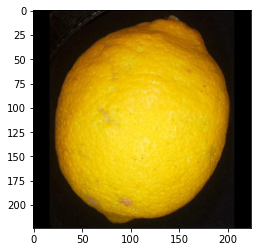

In [36]:
img = cv2.imread('train_images/train_0300.jpg')
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
crop_img = CropLemon()(image=img)['image']
crop_img = cv2.resize(crop_img, (IMG_SIZES[0], IMG_SIZES[0])) 
plt.imshow(crop_img)

In [169]:
def get_file(path1, path2, files, img_arrays=[], labels=[]):
    num = 1
    ids = files["id"]
    classes = files.class_num
    for file in ids:
        if num <= 1102:
            print("{}/{}".format(num, len(df_image_id)))
            img = cv2.imread(DATADIR_TRAIN+file)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            crop_img = CropLemon()(image=img)['image']
            img_array = cv2.resize(crop_img, (IMG_SIZES[3], IMG_SIZES[3]))  # 画像のリサイズ
            img_arrays.append(img_array)
            num += 1
        elif num > 1102:
            print("{}/{}".format(num, len(df_image_id)))
            img = cv2.imread(DATADIR_TEST+file)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            crop_img = CropLemon()(image=img)['image']
            img_array = cv2.resize(crop_img, (IMG_SIZES[3], IMG_SIZES[3]))  # 画像のリサイズ
            img_arrays.append(img_array)
            num += 1
            
    for label in classes:
        labels.append(label)
    
    return img_arrays, labels

In [170]:
img_arrays, labels = get_file(DATADIR_TRAIN, DATADIR_TEST, df)

1/2753
2/2753
3/2753
4/2753
5/2753
6/2753
7/2753
8/2753
9/2753
10/2753
11/2753
12/2753
13/2753
14/2753
15/2753
16/2753
17/2753
18/2753
19/2753
20/2753
21/2753
22/2753
23/2753
24/2753
25/2753
26/2753
27/2753
28/2753
29/2753
30/2753
31/2753
32/2753
33/2753
34/2753
35/2753
36/2753
37/2753
38/2753
39/2753
40/2753
41/2753
42/2753
43/2753
44/2753
45/2753
46/2753
47/2753
48/2753
49/2753
50/2753
51/2753
52/2753
53/2753
54/2753
55/2753
56/2753
57/2753
58/2753
59/2753
60/2753
61/2753
62/2753
63/2753
64/2753
65/2753
66/2753
67/2753
68/2753
69/2753
70/2753
71/2753
72/2753
73/2753
74/2753
75/2753
76/2753
77/2753
78/2753
79/2753
80/2753
81/2753
82/2753
83/2753
84/2753
85/2753
86/2753
87/2753
88/2753
89/2753
90/2753
91/2753
92/2753
93/2753
94/2753
95/2753
96/2753
97/2753
98/2753
99/2753
100/2753
101/2753
102/2753
103/2753
104/2753
105/2753
106/2753
107/2753
108/2753
109/2753
110/2753
111/2753
112/2753
113/2753
114/2753
115/2753
116/2753
117/2753
118/2753
119/2753
120/2753
121/2753
122/2753
123/2753
1

(<matplotlib.image.AxesImage at 0x7efa1107c290>, Text(0.5, 1.0, '2.0'))

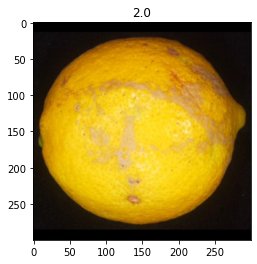

In [171]:
plt.imshow(img_arrays[30]), plt.title(labels[30])

# Tensorflowを使ったデータセットの作製

In [172]:
# 正規化
x_train = img_arrays[:1102]
x_test = img_arrays[1102:]
y_train = labels[:1102]
y_test = labels[1102:]

x_train = np.asarray(x_train) / 255.
x_test = np.asarray(x_test) / 255.
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(<matplotlib.image.AxesImage at 0x7efa11159790>, Text(0.5, 1.0, '1.0'))

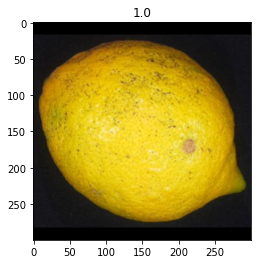

In [173]:
plt.imshow(x_train[10]), plt.title(y_train[10])

In [175]:
batch_size = BATCH_SIZES[0]
input_size = (IMG_SIZES[3], IMG_SIZES[3])

In [190]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.1, #10 for validation 
    rotation_range=360,
      # これらはfitが必要になる memory errorの原因
#     zca_whitening=True,
#     zca_epsilon=1e-06,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
#     zoom_range=[0.5,1.0],
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.1)

train_datagen.fit(x_train, seed = SEED)
valid_datagen.fit(x_train, seed = SEED)

In [191]:
train_generator = train_datagen.flow(
                                               x_train, 
                                               y_train, 
                                               batch_size = batch_size
                                              )

valid_generator = valid_datagen.flow(
                                               x_train, 
                                               y_train, 
                                               batch_size = batch_size
                                               )

In [192]:
batch1, batch2 = train_generator.next()

In [193]:
df_train.class_num = df_train.astype("str")

In [194]:
batch1.shape

(32, 300, 300, 3)

In [195]:
df_train["class_num"] = df_train["class_num"].astype("str")

In [196]:
batch1 = train_generator.next()

In [197]:
batch1, batch2 =  train_generator.next()

In [198]:
batch1[0].shape

(300, 300, 3)

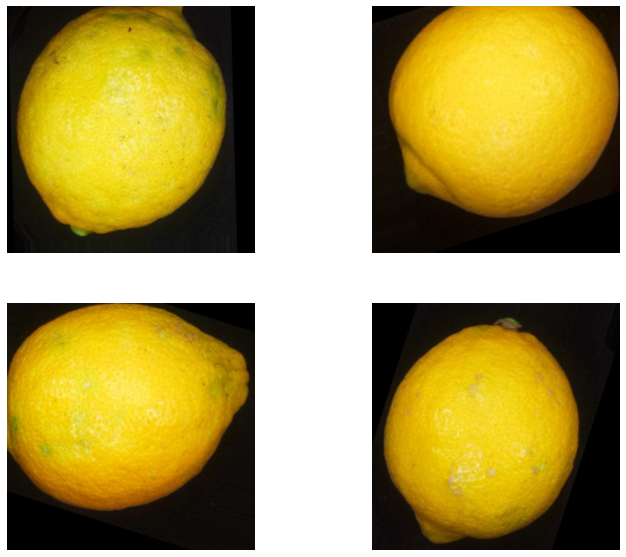

In [199]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    batch1,batch2 = train_generator.next()
    image = batch1[0]
    plt.imshow(image)
    plt.axis("off")
# show the figure
plt.show()

# データセットの作製

In [200]:
y_train.shape

(1102,)

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard

import tensorflow as tf

tf.keras.callbacks.ModelCheckpoint

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [96]:
# モデルの定義

def CNN(x_train, y_train):
    visible = Input(shape=x_train.shape[1:])
    conv1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool1)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    flat = Flatten()(pool2)
    hidden1 = Dense(16, activation='relu')(flat)
    output = Dense(4, activation='softmax')(hidden1)
    model = Model(inputs=visible, outputs=output)

    adam = Adam(lr=1e-3)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    print(model.summary())

    return model

In [97]:
model_cnn = CNN(x_train, y_train)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 221, 221, 32)      1568      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 107, 107, 16)      8208      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                7191

In [98]:
history = model_cnn.fit(train_generator,
    validation_data = valid_generator,
    epochs=20, 
    verbose=1,
    steps_per_epoch = len(df_train)*0.9//batch_size,
    validation_steps = len(df_train)*0.1//batch_size )

Epoch 1/20
20/30 [===================>..........] - ETA: 2s - loss: 1.4388 - accuracy: 0.2284

KeyboardInterrupt: 

In [55]:
pred = model_cnn.predict(x_test)
prediction =np.argmax(pred,axis=1)
df_pred = pd.DataFrame([prediction])

In [56]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,0,3,0,3,1,3,0,1,0,0,...,0,1,1,1,1,1,1,1,2,0


In [150]:
pred_sam.head(6)

,test_0000.jpg,0
0,test_0001.jpg,3
1,test_0002.jpg,0
2,test_0003.jpg,3
3,test_0004.jpg,0
4,test_0005.jpg,0
5,test_0006.jpg,0


In [202]:
import efficientnet.tfkeras as efn

In [203]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

# dim: 入力 df:どのefficientnetを使用するか class_num:分類するクラスの種類
def build_model(dim=IMG_SIZES[0], ef=0, class_num=4):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False, drop_connect_rate=0.4)
    # efficientnetの重みがが変更さえないようにする
#     base.trainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = Dropout(0.3)(x)
    x = tf.keras.layers.Dense(class_num,activation='softmax')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [204]:
def fine_model(dim = IMG_SIZES[0], ef = 0, class_num = 4):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False, drop_connect_rate=0.4)
    # efficientnetの重みがが変更さえないようにする
    base.trainable = False
    # モデルのファインチューニングを行う
    def fine_turning(model):
        for layer in model.layers[-20:]:
            # batch normalization 以外の layer の学習を可能にする
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True
    fine_turning(base)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(class_num,activation='softmax')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [105]:
base = EFNS[0](input_shape=(224,224,3),weights='imagenet',include_top=False, drop_connect_rate=0.4)



In [74]:
base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [70]:
# efficientnet b0 の層の数
len(base.layers)

230

In [207]:
model_3 = build_model(dim=IMG_SIZES[3], ef=3)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnet-b3 (Functional) (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 6148      
Total params: 10,789,676
Trainable params: 10,702,380
Non-trainable params: 87,296
_________________________________________________________________


In [107]:
model_fine = fine_model()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________


# 学習スケジュールfine_model

学習スケジュールとファインチューニングは行わないほうが精度が出やすかった

In [76]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * 8 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    return lr_callback

In [209]:
model_checkpoint = ModelCheckpoint(
        filepath='best_model_efficnetb3.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True ,
        save_freq='epoch')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [210]:
model_checkpoint2 = ModelCheckpoint(
        filepath='best_model_efficnetb3.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True ,
        save_freq='epoch')

In [211]:
history = model_3.fit(train_generator,
    validation_data = valid_generator,
    callbacks = [early_stopping, model_checkpoint],
    epochs=30, 
    verbose=1,
    steps_per_epoch = len(df_train)*0.9//batch_size,
    validation_steps = len(df_train)*0.1//batch_size )

Epoch 1/30
30/30 [==============================] - 53s 1s/step - loss: 1.1937 - accuracy: 0.4787 - val_loss: 1.5918 - val_accuracy: 0.3958
Epoch 2/30
30/30 [==============================] - 33s 1s/step - loss: 0.6011 - accuracy: 0.7921 - val_loss: 1.9677 - val_accuracy: 0.3021
Epoch 3/30
30/30 [==============================] - 33s 1s/step - loss: 0.3827 - accuracy: 0.8728 - val_loss: 1.7088 - val_accuracy: 0.3958
Epoch 4/30
30/30 [==============================] - 33s 1s/step - loss: 0.2621 - accuracy: 0.9092 - val_loss: 1.6883 - val_accuracy: 0.3542
Epoch 5/30
30/30 [==============================] - 33s 1s/step - loss: 0.2370 - accuracy: 0.9166 - val_loss: 1.3601 - val_accuracy: 0.4792
Epoch 6/30
30/30 [==============================] - 33s 1s/step - loss: 0.1821 - accuracy: 0.9358 - val_loss: 1.0344 - val_accuracy: 0.5625
Epoch 7/30
30/30 [==============================] - 33s 1s/step - loss: 0.1807 - accuracy: 0.9384 - val_loss: 0.6310 - val_accuracy: 0.6979
Epoch 8/30
30/30 [==

In [ ]:
history2 = model_fine.fit(train_generator,
    validation_data = valid_generator,
    callbacks = [early_stopping, model_checkpoint],
    epochs=50, 
    verbose=1,
    steps_per_epoch = len(df_train)*0.9//batch_size,
    validation_steps = len(df_train)*0.1//batch_size )

In [212]:
pred = model_3.predict(x_test)
prediction =np.argmax(pred,axis=1)
df_pred = pd.DataFrame([prediction])

In [213]:
model_3.evaluate(x_train,y_train)

35/35 [==============================] - 9s 195ms/step - loss: 0.0037 - accuracy: 1.0000


[0.0036694121081382036, 1.0]

In [215]:
pred2 = pd.read_csv("submit_efn_checkpoint.csv", names=["photo", "class_num"])

In [220]:
pred3 = pd.read_csv("sample_submit.csv", names=["photo", "class_num"])

In [126]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,0,3,0,3,0,0,0,1,3,1,...,0,1,1,1,0,1,1,2,0,0


In [146]:
df_predn

,0,1,2,3,4,5,6,7,8,9,...,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650
0,0,3,0,3,0,0,0,2,3,2,...,0,2,1,1,0,1,1,2,0,0


In [219]:
# cnnのモデルとチェック
count = 0
counter = []
for i in range(len(pred2.class_num)):
    if pred2.class_num[i] == df_pred[i][0]:
        count += 1
    else:
        print("{}がちがう cnnの予想は{}, efnの予想は{}".format(i, pred2.class_num[i], df_pred[i][0]))
        counter.append(i)
print("{}%".format((count/len(pred2.class_num))*100))

16がちがう cnnの予想は1, efnの予想は2
17がちがう cnnの予想は1, efnの予想は0
30がちがう cnnの予想は1, efnの予想は0
61がちがう cnnの予想は0, efnの予想は2
65がちがう cnnの予想は3, efnの予想は2
69がちがう cnnの予想は1, efnの予想は2
85がちがう cnnの予想は1, efnの予想は0
87がちがう cnnの予想は1, efnの予想は2
91がちがう cnnの予想は3, efnの予想は1
94がちがう cnnの予想は1, efnの予想は2
101がちがう cnnの予想は2, efnの予想は3
115がちがう cnnの予想は2, efnの予想は3
120がちがう cnnの予想は3, efnの予想は2
133がちがう cnnの予想は2, efnの予想は0
152がちがう cnnの予想は1, efnの予想は2
160がちがう cnnの予想は3, efnの予想は2
164がちがう cnnの予想は3, efnの予想は2
178がちがう cnnの予想は3, efnの予想は1
194がちがう cnnの予想は2, efnの予想は3
197がちがう cnnの予想は2, efnの予想は1
201がちがう cnnの予想は2, efnの予想は3
202がちがう cnnの予想は1, efnの予想は2
208がちがう cnnの予想は2, efnの予想は1
214がちがう cnnの予想は3, efnの予想は2
236がちがう cnnの予想は2, efnの予想は0
239がちがう cnnの予想は1, efnの予想は2
280がちがう cnnの予想は2, efnの予想は3
291がちがう cnnの予想は3, efnの予想は2
297がちがう cnnの予想は2, efnの予想は3
305がちがう cnnの予想は3, efnの予想は2
317がちがう cnnの予想は3, efnの予想は2
332がちがう cnnの予想は1, efnの予想は2
343がちがう cnnの予想は3, efnの予想は2
353がちがう cnnの予想は1, efnの予想は2
356がちがう cnnの予想は2, efnの予想は0
359がちがう cnnの予想は2, efnの予想は1
376がちがう cnnの予想は1, efnの予想は0
402がちがう cnn

In [221]:
# 1回目のefn0モデルとチェック
count = 0
counter2 = []
for i in range(len(pred3.class_num)):
    if pred3.class_num[i] == df_pred[i][0]:
        count += 1
    else:
        print("{}がちがう cnnの予想は{}, efnの予想は{}".format(i, pred3.class_num[i], df_pred[i][0]))
        counter2.append(i)
print("{}%".format((count/len(pred2.class_num))*100))

9がちがう cnnの予想は3, efnの予想は2
16がちがう cnnの予想は0, efnの予想は2
18がちがう cnnの予想は1, efnの予想は2
23がちがう cnnの予想は3, efnの予想は2
36がちがう cnnの予想は2, efnの予想は1
37がちがう cnnの予想は2, efnの予想は1
39がちがう cnnの予想は0, efnの予想は2
44がちがう cnnの予想は2, efnの予想は1
46がちがう cnnの予想は0, efnの予想は1
54がちがう cnnの予想は0, efnの予想は2
58がちがう cnnの予想は0, efnの予想は2
60がちがう cnnの予想は3, efnの予想は1
61がちがう cnnの予想は0, efnの予想は2
64がちがう cnnの予想は0, efnの予想は1
65がちがう cnnの予想は3, efnの予想は2
66がちがう cnnの予想は2, efnの予想は1
77がちがう cnnの予想は1, efnの予想は2
78がちがう cnnの予想は1, efnの予想は2
85がちがう cnnの予想は3, efnの予想は0
86がちがう cnnの予想は1, efnの予想は2
91がちがう cnnの予想は3, efnの予想は1
94がちがう cnnの予想は0, efnの予想は2
106がちがう cnnの予想は0, efnの予想は2
112がちがう cnnの予想は2, efnの予想は1
113がちがう cnnの予想は0, efnの予想は2
120がちがう cnnの予想は3, efnの予想は2
123がちがう cnnの予想は1, efnの予想は2
127がちがう cnnの予想は3, efnの予想は2
132がちがう cnnの予想は2, efnの予想は1
137がちがう cnnの予想は0, efnの予想は2
138がちがう cnnの予想は1, efnの予想は2
140がちがう cnnの予想は2, efnの予想は1
144がちがう cnnの予想は3, efnの予想は2
150がちがう cnnの予想は0, efnの予想は1
153がちがう cnnの予想は0, efnの予想は2
158がちがう cnnの予想は0, efnの予想は1
160がちがう cnnの予想は3, efnの予想は2
164がちがう cnnの予想は3, efnの予想

In [149]:
# model_check_pointを使用したときとしていない時でチェック
count = 0
counter3 = []
for i in range(len(pred3.class_num)):
    if df_predn[i][0] == df_pred[i][0]:
        count += 1
    else:
        print("{}がちがう efn1の予想は{}, efn2の予想は{}".format(i, df_pred[i][0], df_predn[i][0]))
        counter3.append(i)
print("{}%".format((count/len(pred2.class_num))*100))

7がちがう efn1の予想は1, efn2の予想は2
9がちがう efn1の予想は1, efn2の予想は2
61がちがう efn1の予想は2, efn2の予想は0
101がちがう efn1の予想は3, efn2の予想は2
106がちがう efn1の予想は1, efn2の予想は2
133がちがう efn1の予想は1, efn2の予想は2
181がちがう efn1の予想は1, efn2の予想は2
190がちがう efn1の予想は1, efn2の予想は0
196がちがう efn1の予想は1, efn2の予想は2
197がちがう efn1の予想は1, efn2の予想は2
209がちがう efn1の予想は3, efn2の予想は2
238がちがう efn1の予想は1, efn2の予想は2
253がちがう efn1の予想は1, efn2の予想は2
259がちがう efn1の予想は2, efn2の予想は3
290がちがう efn1の予想は2, efn2の予想は1
291がちがう efn1の予想は2, efn2の予想は3
305がちがう efn1の予想は2, efn2の予想は3
308がちがう efn1の予想は1, efn2の予想は2
310がちがう efn1の予想は1, efn2の予想は0
320がちがう efn1の予想は2, efn2の予想は0
351がちがう efn1の予想は1, efn2の予想は2
435がちがう efn1の予想は3, efn2の予想は2
450がちがう efn1の予想は1, efn2の予想は2
468がちがう efn1の予想は2, efn2の予想は1
530がちがう efn1の予想は2, efn2の予想は1
531がちがう efn1の予想は1, efn2の予想は2
553がちがう efn1の予想は1, efn2の予想は2
573がちがう efn1の予想は1, efn2の予想は3
588がちがう efn1の予想は1, efn2の予想は2
589がちがう efn1の予想は1, efn2の予想は2
610がちがう efn1の予想は1, efn2の予想は3
631がちがう efn1の予想は1, efn2の予想は2
695がちがう efn1の予想は2, efn2の予想は3
712がちがう efn1の予想は1, efn2の予想は2
735がちがう efn1の予想は1, 

In [141]:
count_fin = 0
for i in range(len(counter)):
    if counter[i] in counter2:
        count_fin += 1
print(count_fin/len(counter)) 

0.6989795918367347


In [222]:
k3 = [df_pred[i][0] for i in range(len(pred2.class_num))]

In [151]:
k2 = [df_predn[i][0] for i in range(len(pred2.class_num))]

In [154]:
df_test["preds"] = k3

df_test

df_test.to_csv("submit_efn_.csv", index = False, header = None)

dfdf = pd.read_csv("submit_efn_2.csv")

In [157]:
df_test["preds"] = k2

df_test

df_test.to_csv("submit_efn_checkpoint.csv", index = False, header = None)

dfdf2 = pd.read_csv("submit_efn_checkpoint.csv")

In [161]:
dfdf.tail(10)

,test_0000.jpg,0
1640,test_1641.jpg,0
1641,test_1642.jpg,1
1642,test_1643.jpg,1
1643,test_1644.jpg,1
1644,test_1645.jpg,0
1645,test_1646.jpg,1
1646,test_1647.jpg,1
1647,test_1648.jpg,2
1648,test_1649.jpg,0
1649,test_1650.jpg,0
